In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import copy
import shap
import pickle
import os

from scipy import linalg
from scipy.special import expit
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, 
                             RocCurveDisplay, PrecisionRecallDisplay)
from pandas.api.types import CategoricalDtype

In [2]:
# Import MICE functions
from mice_functions import *

## Load incomplete dataset

In [3]:
# Load incomplete dataset
props_name = [10, 20, 30, 40, 50]
boston_path = "../../data/toy-dataset/boston-processed/"
biopsy_path = "../../data/toy-dataset/biopsy-processed/"

# Starting with boston dataset
boston_incomp = {}
for p in props_name:
    boston_incomp[p] = pd.read_csv(boston_path + "boston_{}.csv".format(p))


# Followed by biopsy dataset
biopsy_incomp = {}
for p in props_name:
    biopsy_incomp[p] = pd.read_csv(biopsy_path + "biopsy_{}.csv".format(p))

In [4]:
# List down target variables for imputation
boston_targets_cat = ["chas"]
boston_targets_num = ["nox"]

biopsy_targets_cat = []
biopsy_targets_num = ["V1", "V2", "V3"]

## Apply MICE algorithm
### General setup

In [11]:
# Select imputation models
method_cat = "boot"
method_num = "pmm"

# Set number of imputations and maximum number of iteration
maxit = 40
m = 20

# Set number of donors for PMM
d = 10

# Set random seed
SEED = 2023

# Path to store any plots assessing convergence
conv_path = "../../results/figures/python_convergence/"
if not os.path.exists(conv_path):
    os.mkdir(conv_path)

### `boston` dataset

Applying on dataset 10


100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.58it/s]


Applying on dataset 20


100%|███████████████████████████████████████████| 40/40 [00:05<00:00,  7.15it/s]


Applying on dataset 30


100%|███████████████████████████████████████████| 40/40 [00:06<00:00,  6.54it/s]


Applying on dataset 40


100%|███████████████████████████████████████████| 40/40 [00:06<00:00,  6.23it/s]


Applying on dataset 50


100%|███████████████████████████████████████████| 40/40 [00:06<00:00,  5.83it/s]


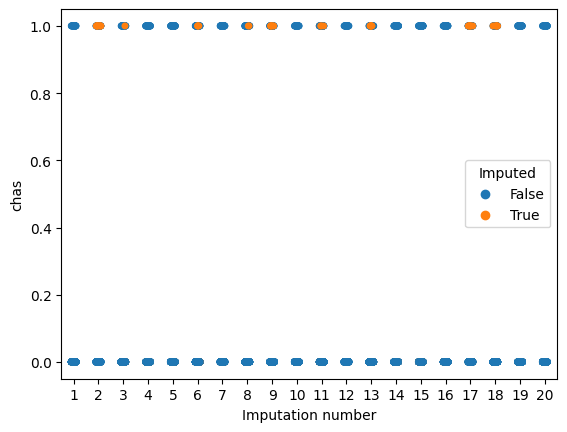

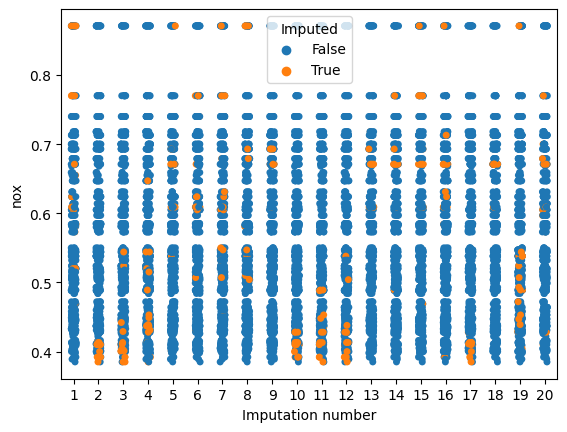

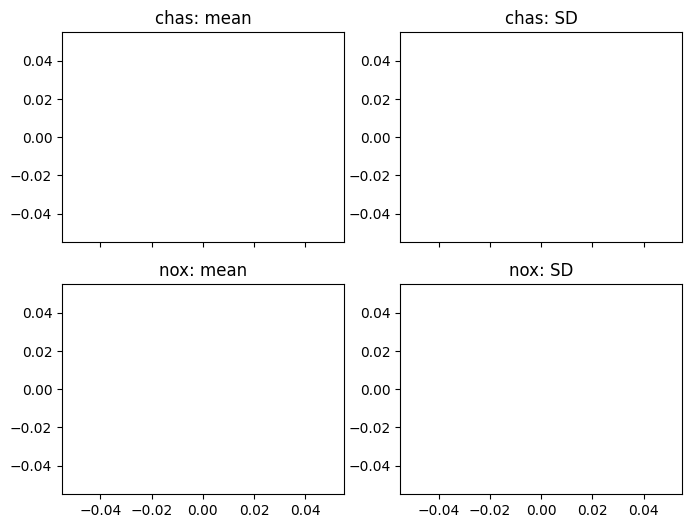

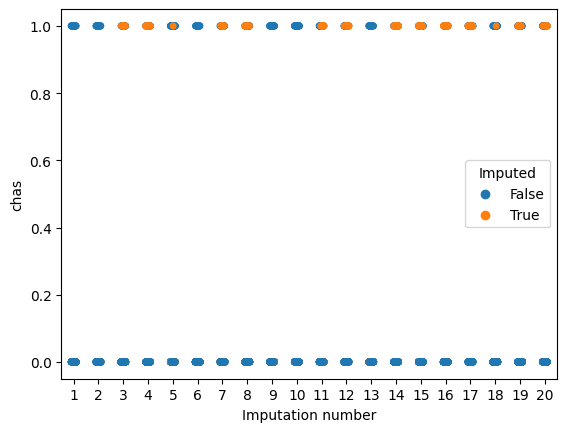

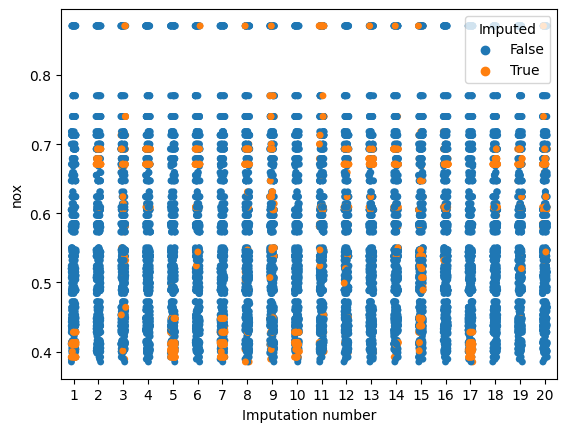

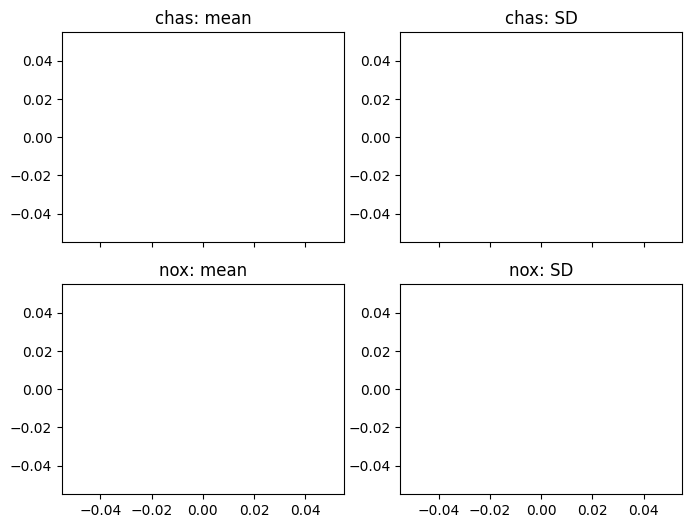

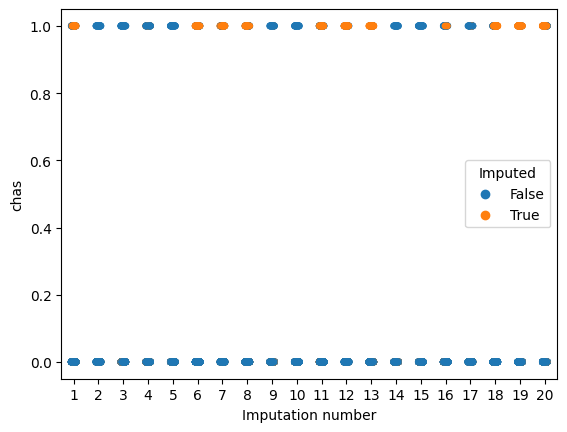

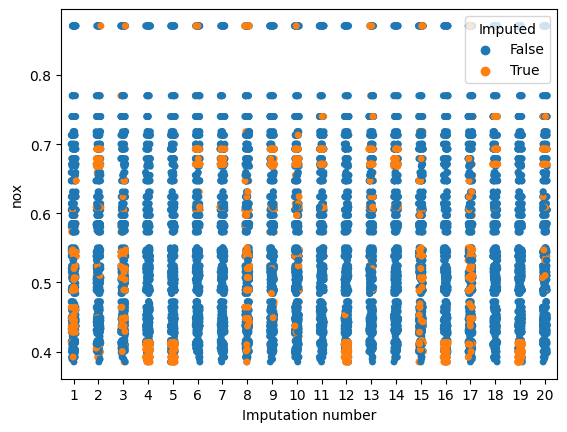

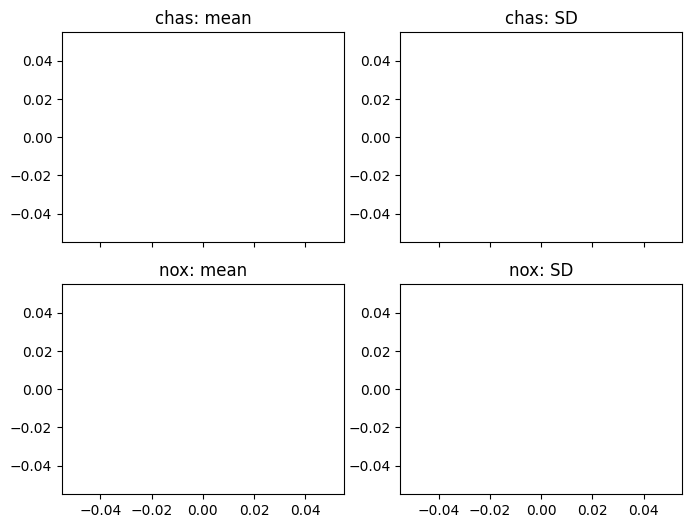

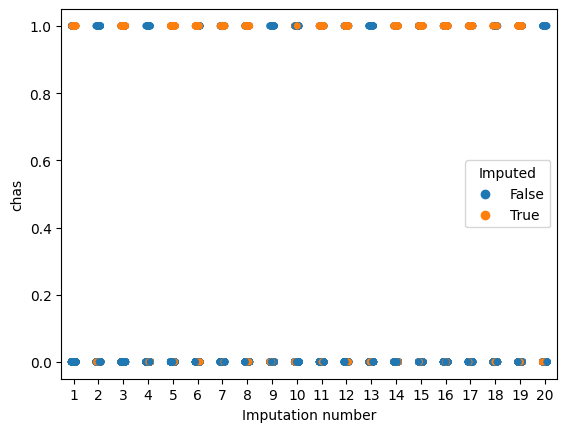

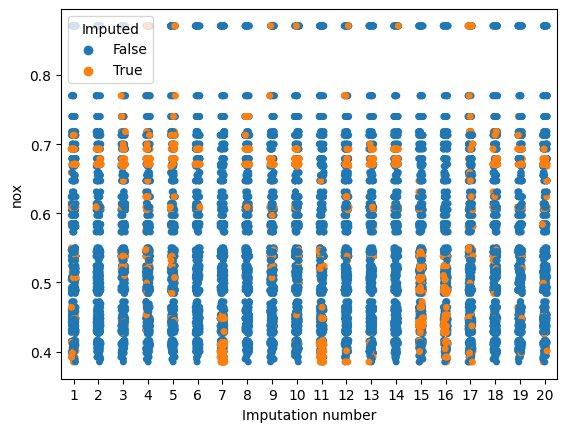

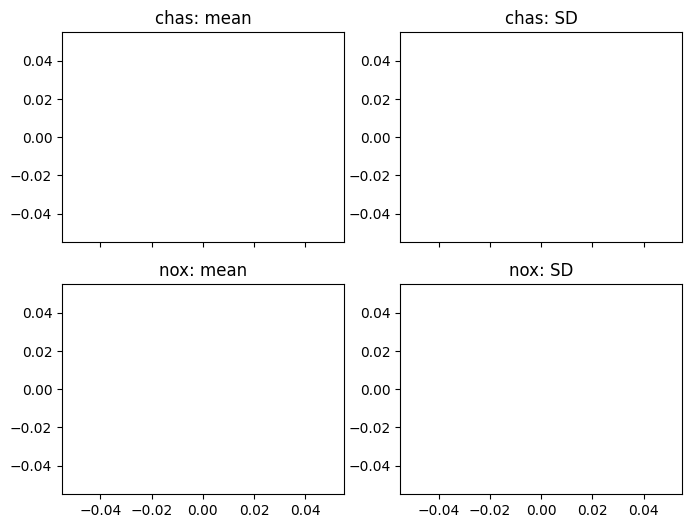

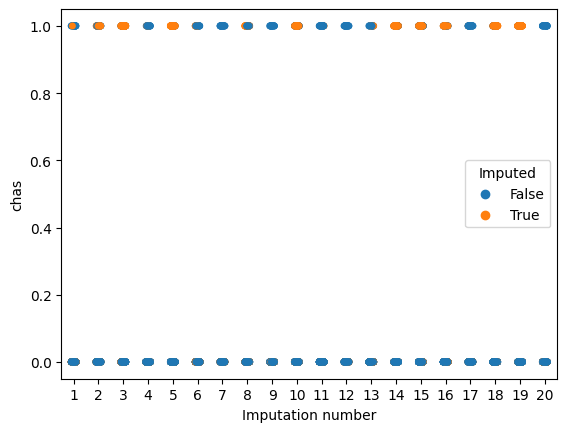

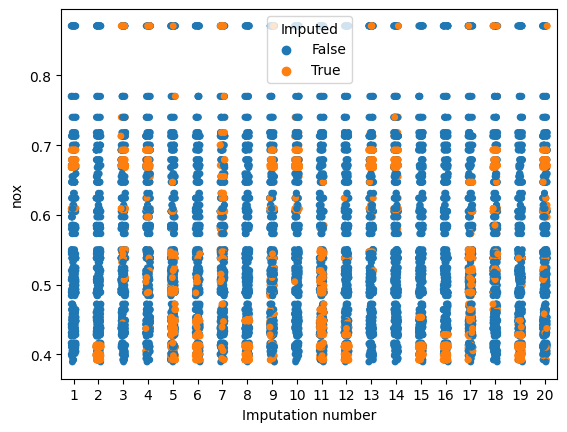

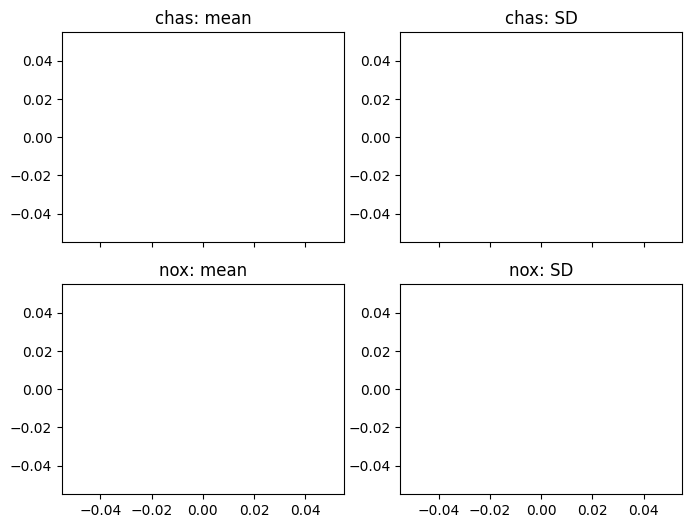

In [12]:
# Prevent plots from being printed
%matplotlib agg

# Prepare dictionary to store imputed data
boston_imputed = {}

for p in props_name:
    print("Applying on dataset {}".format(p))
    
    # Apply MICE algorithm
    boston_imputed[p] = MICE(boston_incomp[p], boston_targets_cat, boston_targets_num, 
                             m=m, maxit=maxit, d=d, seed=SEED, 
                             method_cat=method_cat, method_num=method_num)
    
    # Construct trace plot
    f = ChainStatsViz(boston_imputed[p])
    f.savefig(conv_path + "boston_traceplot_{}.pdf".format(p))
    
    # Construct strip plots for imputed variables
    for c in ["chas", "nox"]:
        f = plotImputedData(boston_imputed[p], c)
        f.savefig(conv_path + "boston_{}_stripplot_{}.pdf".format(c, p))

In [ ]:
# Save multiply imputed data as Python objects
with open(boston_path + "imputed.pickle", "wb") as handle:
    pickle.dump(boston_imputed, handle, protocol=pickle.HIGHEST_PROTOCOL)

### `biopsy` dataset

 28%|███████████▊                               | 11/40 [00:03<00:08,  3.39it/s]


 60%|█████████████████████████▊                 | 24/40 [00:08<00:05,  2.69it/s]


100%|█████████████████████████████████████████████| 5/5 [01:19<00:00, 15.80s/it]


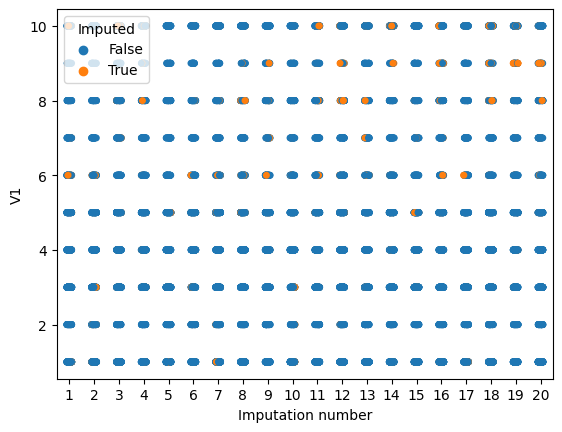

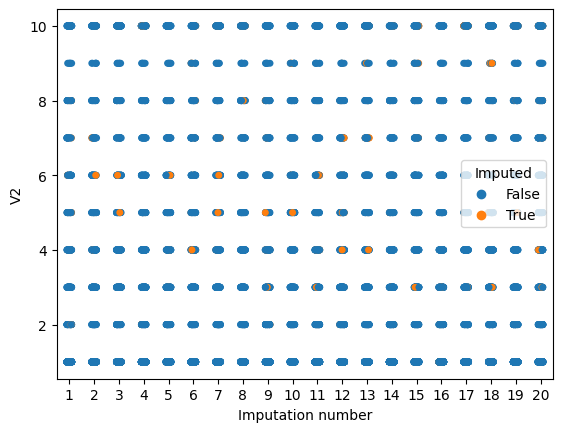

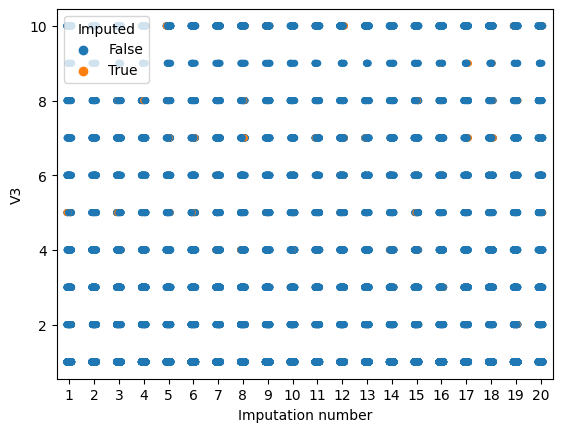

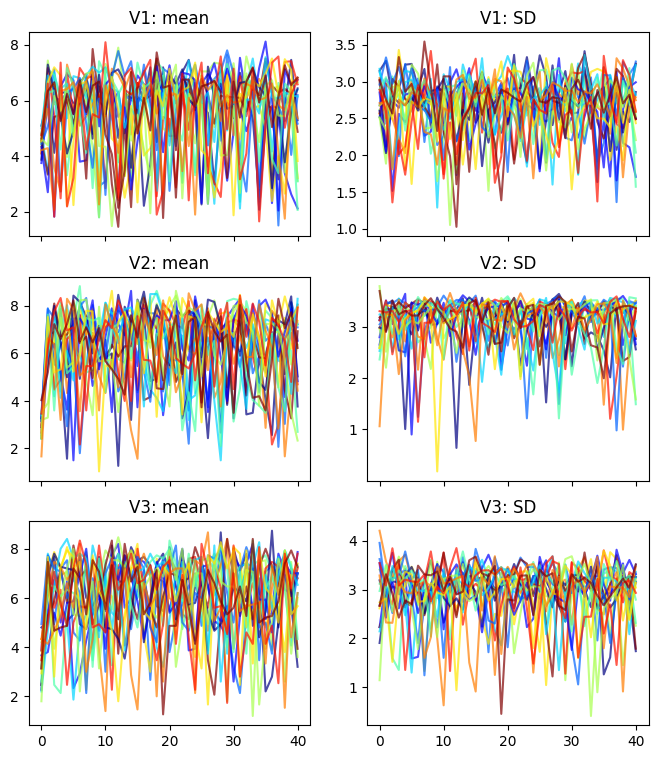

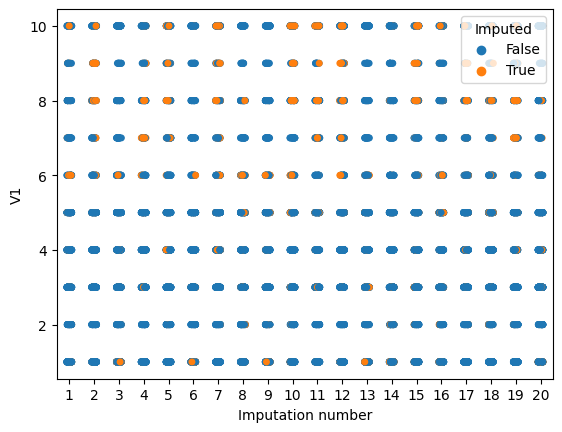

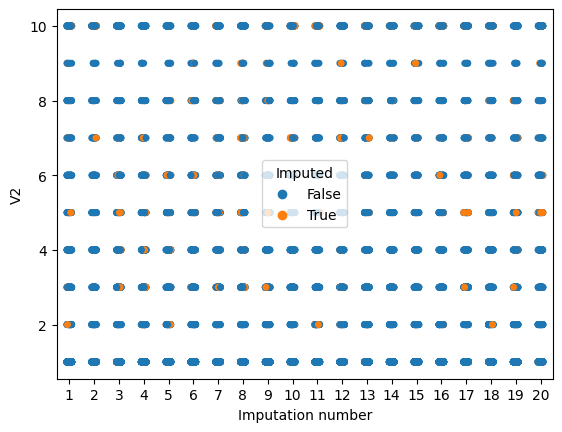

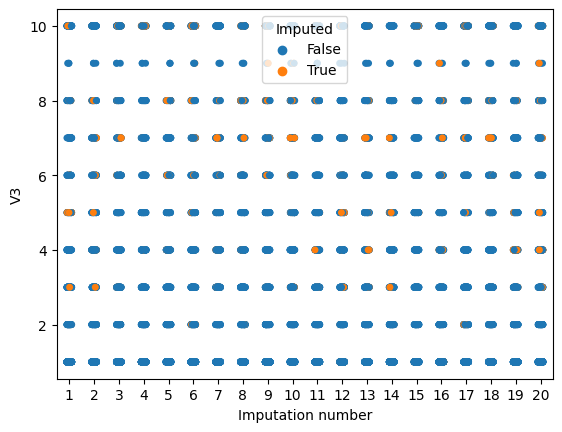

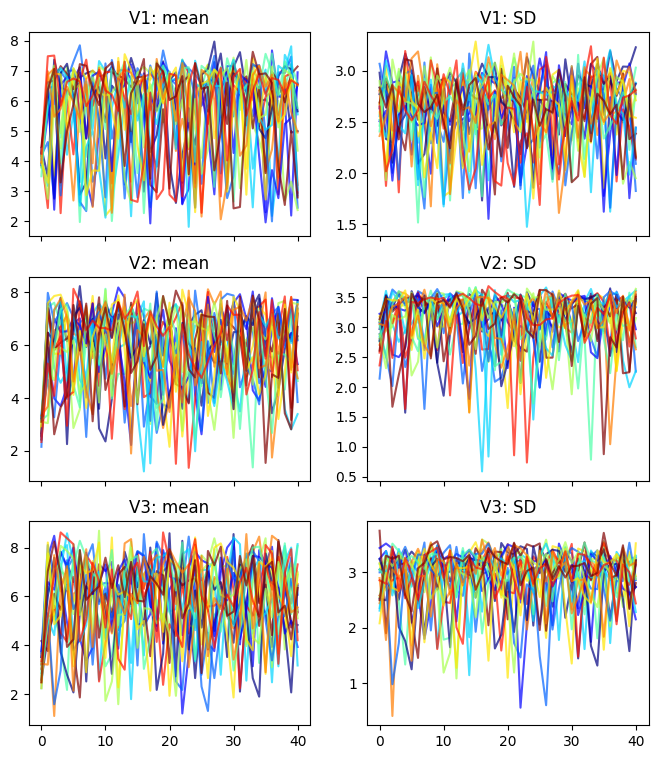

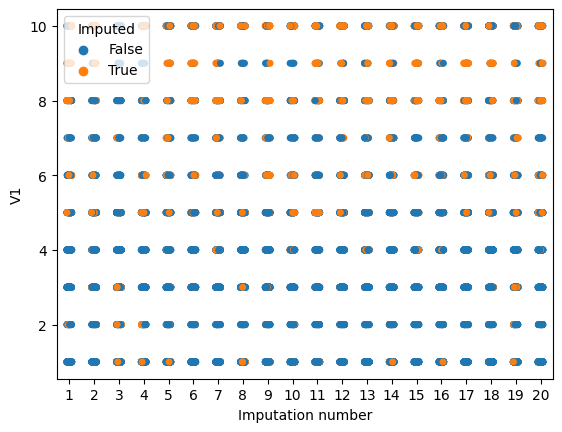

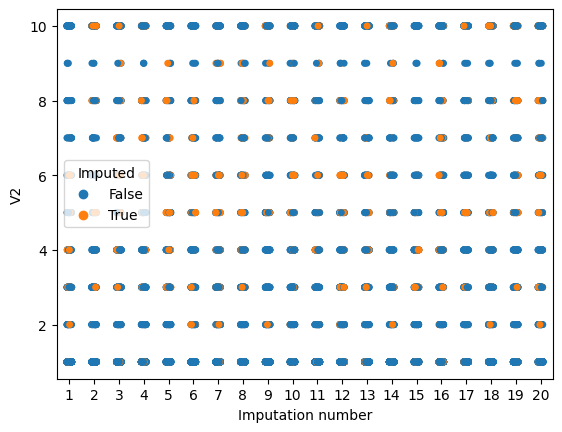

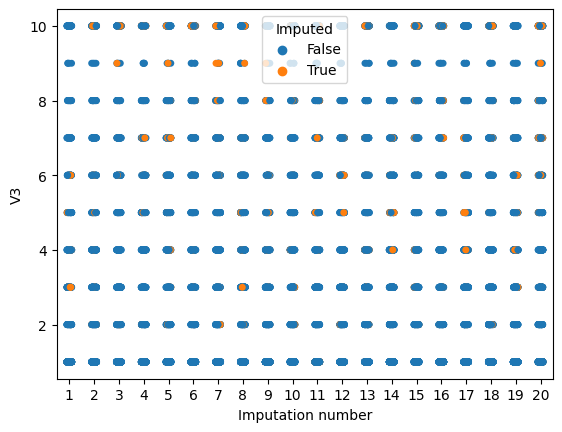

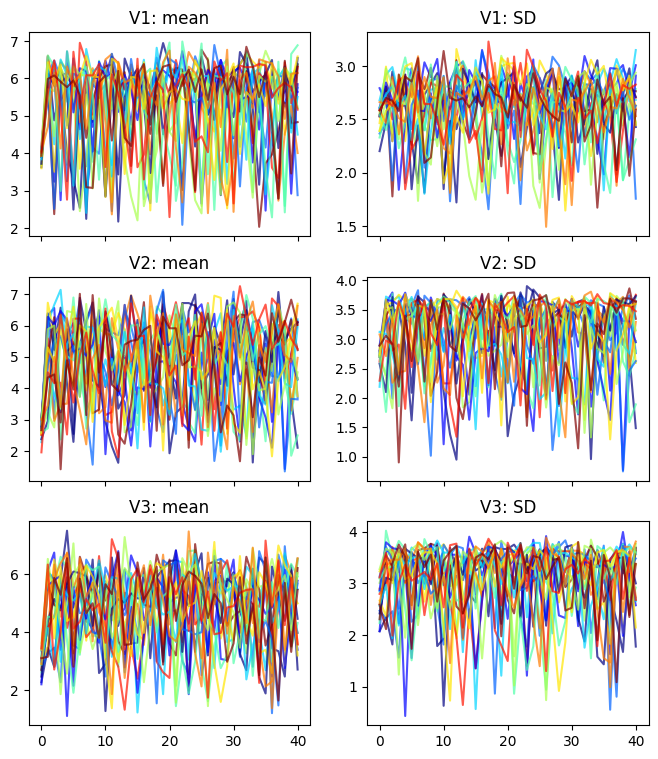

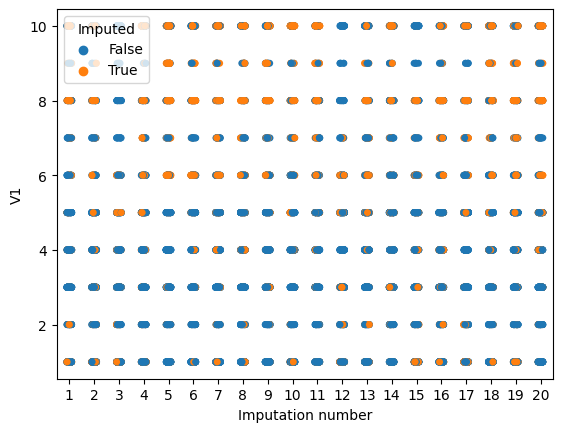

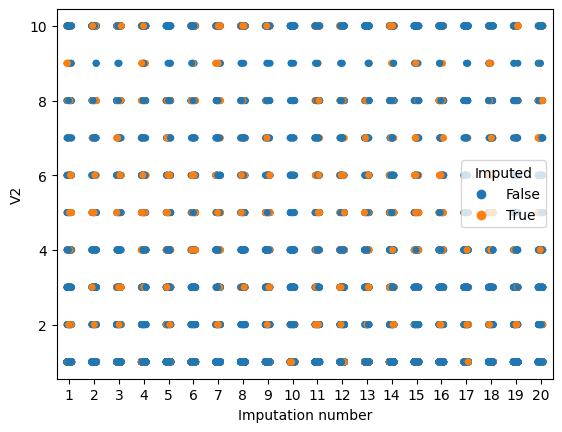

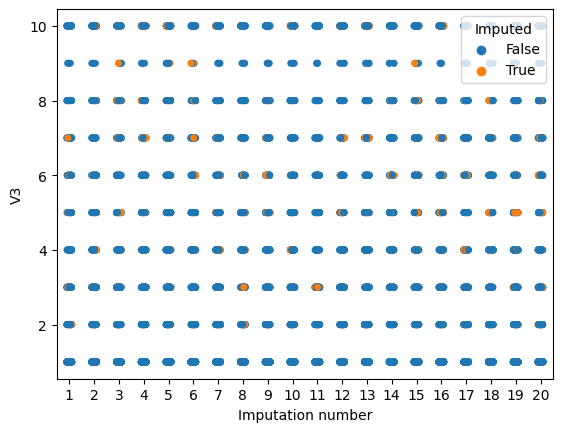

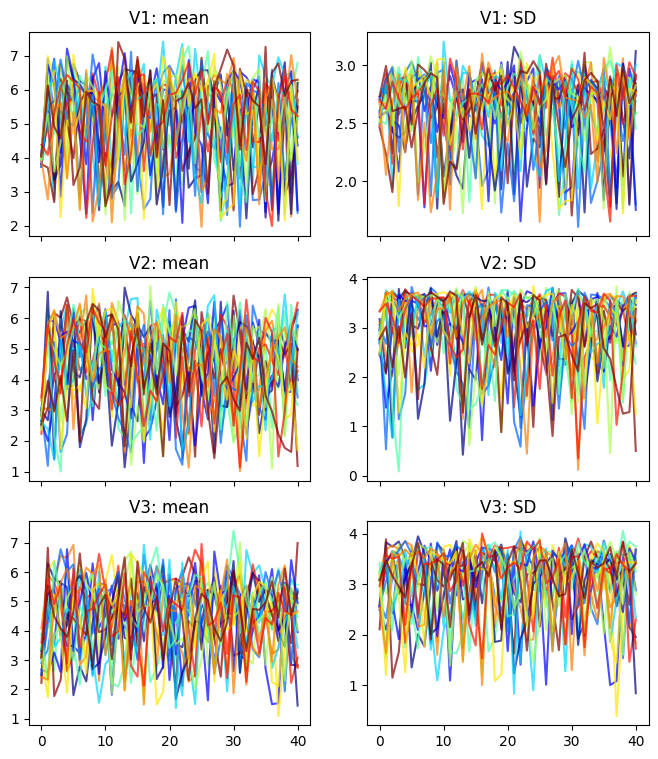

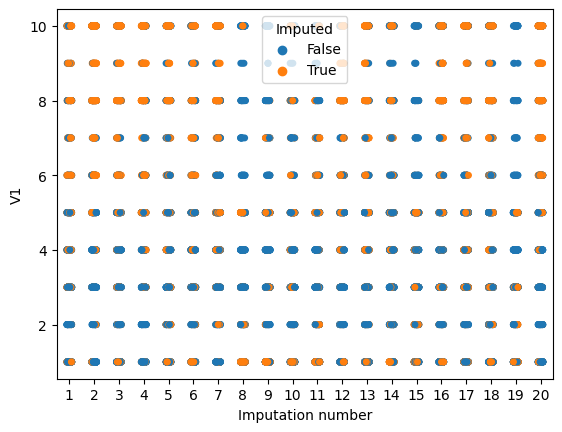

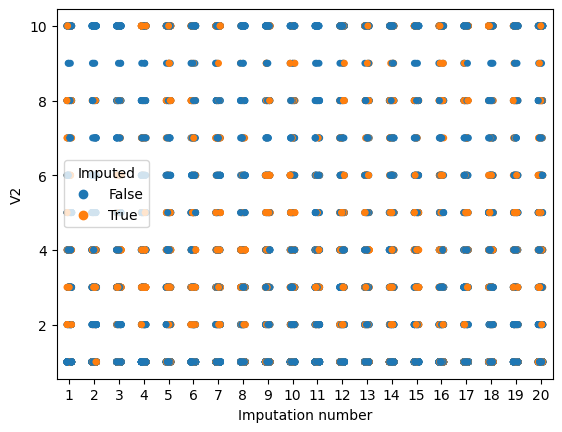

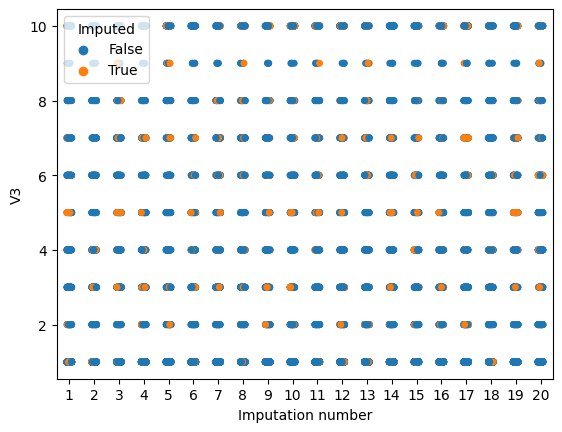

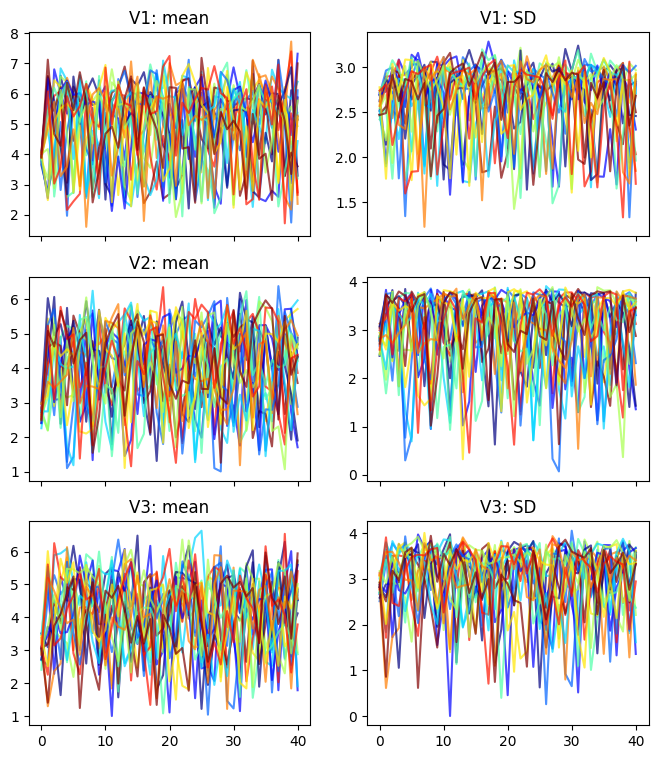

In [9]:
# Prepare dictionary to store imputed data
biopsy_imputed = {}

for p in props_name:
    print("Applying on dataset {}".format(p))
    
    # Apply MICE algorithm
    biopsy_imputed[p] = MICE(biopsy_incomp[p], biopsy_targets_cat, biopsy_targets_num, 
                             m=m, maxit=maxit, d=d, seed=SEED, 
                             method_cat=method_cat, method_num=method_num)
    
    # Construct trace plot
    f = ChainStatsViz(biopsy_imputed[p])
    f.savefig(conv_path + "biopsy_traceplot_{}.pdf".format(p))
    
    # Construct strip plots for imputed variables
    for c in ["V1", "V2", "V3"]:
        f = plotImputedData(biopsy_imputed[p], c)
        f.savefig(conv_path + "biopsy_{}_stripplot_{}.pdf".format(c, p))

In [10]:
# Save multiply imputed data as Python objects
with open(biopsy_path + "imputed.pickle", "wb") as handle:
    pickle.dump(biopsy_imputed, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Apply complete case analysis

### `boston` dataset

In [ ]:
# Prepare dictionary to store complete case data
boston_cc = {}

for p in tqdm(props_name):
    # Apply complete case analysis on each dataset
    boston_cc[p] = boston_incomp[p].dropna()
    print("Proportion = {}. Dimension of complete case data = {}".format(
        p/100, boston_cc[p].shape))

In [ ]:
# Create directory if not present yet
boston_cc_path = "../../data/toy-dataset/boston-complete-case/"
if not os.path.exists(boston_cc_path):
    os.mkdir(boston_cc_path)

# Store complete case data
for p in props_name:
    boston_cc[p].to_csv(boston_cc_path + "boston_{}.csv".format(p), 
                        index=False)

### `biopsy` dataset

In [ ]:
# Prepare dictionary to store complete case data
biopsy_cc = {}

for p in tqdm(props_name):
    # Apply complete case analysis on each dataset
    biopsy_cc[p] = biopsy_incomp[p].dropna()
    print("Proportion = {}. Dimension of complete case data = {}".format(
        p/100, biopsy_cc[p].shape))

In [ ]:
# Create directory if not present yet
biopsy_cc_path = "../../data/toy-dataset/biopsy-complete-case/"
if not os.path.exists(biopsy_cc_path):
    os.mkdir(biopsy_cc_path)

# Store complete case data
for p in props_name:
    biopsy_cc[p].to_csv(biopsy_cc_path + "biopsy_{}.csv".format(p), 
                        index=False)